In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os

# Path to your dataset folder (adjust if needed)
data_path = "/content/drive/MyDrive/Data-Mining/FARS2023NationalCSV"

# Read the PERSONS.csv file
persons_df = pd.read_csv(os.path.join(data_path, "person.csv"))

# Print first 10 rows
# print(persons_df.head(10))

# Print total number of rows
print("\nTotal number of rows:", len(persons_df))

Mounted at /content/drive

Total number of rows: 92400


In [3]:
# Step 1: Initial Data Inspection and Overview

print("Number of rows and columns:", persons_df.shape)

# Display all column names to understand the available features
print("\nList of columns:\n")
print(persons_df.columns.tolist())

# Check for duplicate records (if any)
# duplicate_count = persons_df.duplicated().sum()
# print(f"\nTotal duplicate rows: {duplicate_count}")

# Check for missing/null values in each column
print("\nMissing values per column (top 10 shown):\n")
print(persons_df.isna().sum().sort_values(ascending=False).head(10))

Number of rows and columns: (92400, 126)

List of columns:

['STATE', 'STATENAME', 'ST_CASE', 'VEH_NO', 'PER_NO', 'VE_FORMS', 'COUNTY', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME', 'HARM_EV', 'HARM_EVNAME', 'MAN_COLL', 'MAN_COLLNAME', 'SCH_BUS', 'SCH_BUSNAME', 'RUR_URB', 'RUR_URBNAME', 'FUNC_SYS', 'FUNC_SYSNAME', 'MOD_YEAR', 'MOD_YEARNAME', 'VPICMAKE', 'VPICMAKENAME', 'VPICMODEL', 'VPICMODELNAME', 'VPICBODYCLASS', 'VPICBODYCLASSNAME', 'MAKE', 'MAKENAME', 'BODY_TYP', 'BODY_TYPNAME', 'ICFINALBODY', 'ICFINALBODYNAME', 'GVWR_FROM', 'GVWR_FROMNAME', 'GVWR_TO', 'GVWR_TONAME', 'TOW_VEH', 'TOW_VEHNAME', 'SPEC_USE', 'SPEC_USENAME', 'EMER_USE', 'EMER_USENAME', 'ROLLOVER', 'ROLLOVERNAME', 'IMPACT1', 'IMPACT1NAME', 'FIRE_EXP', 'FIRE_EXPNAME', 'MAK_MOD', 'MAK_MODNAME', 'AGE', 'AGENAME', 'SEX', 'SEXNAME', 'PER_TYP', 'PER_TYPNAME', 'INJ_SEV', 'INJ_SEVNAME', 'SEAT_POS', 'SEAT_POSNAME', 'REST_USE', 'REST_USENAME', 'REST_MIS', 'REST_MISNAME', 'HELM_USE', 'HELM_USEN

In [4]:
# Step 2: Drop Unnecessary / Redundant Columns in Groups
#
# Goal:
#   The PERSONS.csv dataset contains 100+ columns — many of which are repetitive (codes + decoded names), administrative IDs, or overly detailed
#   engineering fields.  For data-mining and pattern analysis, we only need the columns that help explain crash patterns such as:
#       - where/when crashes occurred
#       - who was involved (age, gender, role)
#       - injury severity or fatality
#       - vehicle category
#       - safety equipment / impairment
#
#   Below we remove columns in logical categories while keeping the readable
#   *_NAME fields and the key analytical attributes.
# ----------------------------------------------------

import pandas as pd

# 1️⃣ ID / Administrative Columns
# ----------------------------------------------------
# These are record identifiers or internal numbering fields used by NHTSA
# for indexing — not meaningful for analysis.
# Examples:
#   - ST_CASE : unique case ID for each crash
#   - VEH_NO  : vehicle number within a crash case
#   - PER_NO  : person number within a vehicle
#   - VE_FORMS / COUNTY : administrative details, not needed for pattern mining
drop_ids = [
    #'ST_CASE',     # crash case identifier
    #'VEH_NO',      # vehicle identifier within the crash
    #'PER_NO',      # person identifier within the vehicle
    'VE_FORMS',    # internal form number
    'COUNTY',      # too granular for national-level patterning
]
persons_df = persons_df.drop(columns=drop_ids, errors='ignore')

# 2️⃣ Code Columns (Numeric versions of *_NAME columns)
# ----------------------------------------------------
# In FARS data, each coded variable (numeric) has a descriptive “*_NAME” column.
# Since *_NAME already gives the human-readable label, we can safely remove
# the numeric code columns.  For instance:
#   STATE (01)  → STATENAME ("Alabama")
#   SEX (1)     → SEXNAME ("Male")
# This makes the dataset easier to interpret without losing information.
drop_code_duplicates = [
    'STATE','MONTH','DAY','HOUR','MINUTE',
    'HARM_EV','MAN_COLL','SCH_BUS',
    'RUR_URB','FUNC_SYS','MOD_YEAR',
    'SEX','PER_TYP','INJ_SEV',
    'SEAT_POS','REST_USE','REST_MIS',
    'HELM_USE','HELM_MIS','AIR_BAG','EJECTION','EJ_PATH',
    'EXTRICAT','DRINKING','ALC_STATUS','ATST_TYP','ALC_RES',
    'DRUGS','HOSPITAL','DOA',
    'DEATH_MO','DEATH_DA','DEATH_YR',
    'LAG_HRS','LAG_MINS','DEVTYPE','DEVMOTOR',
    'LOCATION','WORK_INJ','HISPANIC'
]
persons_df = persons_df.drop(columns=drop_code_duplicates, errors='ignore')

# 3️⃣ Detailed Vehicle / Manufacturer Specifications
# ----------------------------------------------------
# These fields describe the exact make, model, and body-class details from
# VIN decoding or manufacturer lookups (VPIC).  While useful for engineering
# research, they add too much dimensionality for high-level crash analysis.
# We will keep general ones like MAKENAME (brand) and BODY_TYPNAME (category),
# but remove deep specifics such as GVWR (weight class), VPICMODEL, etc.
drop_vehicle_details = [
    'VPICMAKE','VPICMAKENAME',
    'VPICMODEL','VPICMODELNAME',
    'VPICBODYCLASS','VPICBODYCLASSNAME',
    'ICFINALBODY','ICFINALBODYNAME',
    'GVWR_FROM','GVWR_FROMNAME','GVWR_TO','GVWR_TONAME',
    'TOW_VEH','TOW_VEHNAME',
    'SPEC_USE','SPEC_USENAME',
    'EMER_USE','EMER_USENAME',
    'IMPACT1','IMPACT1NAME',
    'FIRE_EXP','FIRE_EXPNAME',
    'MAK_MOD','MAK_MODNAME',   # very specific internal model code
    'STR_VEH'                  # structure/vehicle linkage reference
]
persons_df = persons_df.drop(columns=drop_vehicle_details, errors='ignore')

# 4️⃣ Detailed Testing / Alcohol / Lab Results
# ----------------------------------------------------
# These include the type of alcohol test, testing status codes,
# and exact blood-alcohol content results.
# For general crash trend analysis, we only need DRINKINGNAME (yes/no)
# and DRUGSNAME (yes/no), not the lab result metadata.
drop_testing = [
    'ALC_STATUSNAME',  # test status (e.g., Test Given / Not Given)
    'ATST_TYPNAME',    # type of alcohol test (blood, urine, etc.)
    'ALC_RESNAME',     # detailed result string (e.g., "0.217 % BAC")
]
# persons_df = persons_df.drop(columns=drop_testing, errors='ignore')

# 5️⃣ Detailed Death-Time Fields
# ----------------------------------------------------
# These columns record exact hour/minute of death.  If we only care about
# whether the crash was fatal and in which month/year, we can remove
# these time-granular fields.
# We will still retain DEATH_MONAME, DEATH_DANAME, DEATH_YRNAME
# for basic temporal grouping of fatalities.
drop_death_details = [
    # 'DEATH_TMNAME',
    # 'DEATH_HRNAME',
    # 'DEATH_MNNAME',
    'DEATH_TM',
    'DEATH_HR',
    'DEATH_MN'
]
persons_df = persons_df.drop(columns=drop_death_details, errors='ignore')

# 6️⃣ Miscellaneous Sparse / Technical Columns
# ----------------------------------------------------
# These contain time-lag calculations (minutes between crash and death)
# or are mostly empty across records, so we’ll drop them too.
drop_misc = [
    'LAG_HRSNAME','LAG_MINSNAME'
]
persons_df = persons_df.drop(columns=drop_misc, errors='ignore')

# ----------------------------------------------------
# ✅ Check Remaining Columns
# ----------------------------------------------------
print("Columns remaining after cleaning:\n")
print(persons_df.columns.tolist())
print("\nShape after drops:", persons_df.shape)

# Interpretation:
#   The remaining DataFrame should have roughly 25–30 columns, including:
#   - crash context: STATENAME, MONTHNAME, DAYNAME, HOURNAME, RUR_URBNAME, FUNC_SYSNAME
#   - person info: AGE, SEXNAME, HISPANICNAME
#   - outcome info: PER_TYPNAME, INJ_SEVNAME, HOSPITALNAME, DOANAME
#   - vehicle info: MAKENAME, BODY_TYPNAME
#   - safety & impairment: REST_USENAME, AIR_BAGNAME, EJECTIONNAME,
#                         HELM_USENAME, DRINKINGNAME, DRUGSNAME
#   - fatal info (if present): DEATH_MONAME, DEATH_DANAME, DEATH_YRNAME
#
# This cleaned dataset is now interpretable and ready for the next step:
#   → handling missing values and encoding categorical fields for analysis.
# ----------------------------------------------------

Columns remaining after cleaning:

['STATENAME', 'ST_CASE', 'VEH_NO', 'PER_NO', 'MONTHNAME', 'DAYNAME', 'HOURNAME', 'MINUTENAME', 'HARM_EVNAME', 'MAN_COLLNAME', 'SCH_BUSNAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'MOD_YEARNAME', 'MAKE', 'MAKENAME', 'BODY_TYP', 'BODY_TYPNAME', 'ROLLOVER', 'ROLLOVERNAME', 'AGE', 'AGENAME', 'SEXNAME', 'PER_TYPNAME', 'INJ_SEVNAME', 'SEAT_POSNAME', 'REST_USENAME', 'REST_MISNAME', 'HELM_USENAME', 'HELM_MISNAME', 'AIR_BAGNAME', 'EJECTIONNAME', 'EJ_PATHNAME', 'EXTRICATNAME', 'DRINKINGNAME', 'ALC_STATUSNAME', 'ATST_TYPNAME', 'ALC_RESNAME', 'DRUGSNAME', 'DSTATUS', 'DSTATUSNAME', 'HOSPITALNAME', 'DOANAME', 'DEATH_MONAME', 'DEATH_DANAME', 'DEATH_YRNAME', 'DEATH_TMNAME', 'DEATH_HRNAME', 'DEATH_MNNAME', 'DEVTYPENAME', 'DEVMOTORNAME', 'LOCATIONNAME', 'WORK_INJNAME', 'HISPANICNAME']

Shape after drops: (92400, 54)


In [5]:
# ----------------------------------------
# Data Quality Check & Preparation
# ----------------------------------------

# 1. Basic info about the cleaned dataframe
print("Shape:", persons_df.shape)
#print("\nData types:\n")
#print(persons_df.dtypes)

# 2. Check missing values (top 20)
print("\nMissing values per column (top 20):\n")
print(persons_df.isna().sum().sort_values(ascending=False).head(20))

# 3. Make sure AGE is numeric
persons_df['AGE'] = pd.to_numeric(persons_df['AGE'], errors='coerce')

# 4. Handle missing AGE (simple fill with median)
if persons_df['AGE'].isna().sum() > 0:
    persons_df['AGE'].fillna(persons_df['AGE'].median(), inplace=True)

# 5. For key categorical columns, fill NaN with "Unknown"
cat_cols = [
    'STATENAME', 'MONTHNAME', 'DAYNAME', 'HOURNAME',
    'RUR_URBNAME', 'FUNC_SYSNAME',
    'SEXNAME', 'PER_TYPNAME', 'INJ_SEVNAME',
    'REST_USENAME', 'AIR_BAGNAME', 'EJECTIONNAME',
    'DRINKINGNAME', 'DRUGSNAME',
    'HOSPITALNAME', 'DOANAME'
]

for c in cat_cols:
    if c in persons_df.columns:
        persons_df[c].fillna("Unknown", inplace=True)

# 6. Quick check again after fills
print("\nMissing values after basic fills (top 20):\n")
print(persons_df.isna().sum().sort_values(ascending=False).head(10))

Shape: (92400, 54)

Missing values per column (top 20):

DEVMOTORNAME    83113
DEVTYPENAME     83113
ROLLOVER         9287
ROLLOVERNAME     9287
MAKE             9287
BODY_TYPNAME     9287
MAKENAME         9287
MOD_YEARNAME     9287
BODY_TYP         9287
MONTHNAME           0
ST_CASE             0
STATENAME           0
DAYNAME             0
VEH_NO              0
FUNC_SYSNAME        0
RUR_URBNAME         0
SCH_BUSNAME         0
MAN_COLLNAME        0
MINUTENAME          0
HARM_EVNAME         0
dtype: int64

Missing values after basic fills (top 20):



/tmp/ipython-input-1253845688.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  persons_df[c].fillna("Unknown", inplace=True)


DEVMOTORNAME    83113
DEVTYPENAME     83113
ROLLOVER         9287
ROLLOVERNAME     9287
MAKE             9287
BODY_TYPNAME     9287
MAKENAME         9287
MOD_YEARNAME     9287
BODY_TYP         9287
MONTHNAME           0
dtype: int64


In [6]:
# treat missing / blank / non-numeric VEH_NO as 0 (pedestrian)
persons_df["VEH_NO"] = (
    persons_df["VEH_NO"]
    .replace(["", " ", None], 0)
    .fillna(0)
    .astype(int)
)

In [7]:
print("cols:", persons_df.shape[1])
print("name of the columns:", persons_df.columns.tolist())

cols: 54
name of the columns: ['STATENAME', 'ST_CASE', 'VEH_NO', 'PER_NO', 'MONTHNAME', 'DAYNAME', 'HOURNAME', 'MINUTENAME', 'HARM_EVNAME', 'MAN_COLLNAME', 'SCH_BUSNAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'MOD_YEARNAME', 'MAKE', 'MAKENAME', 'BODY_TYP', 'BODY_TYPNAME', 'ROLLOVER', 'ROLLOVERNAME', 'AGE', 'AGENAME', 'SEXNAME', 'PER_TYPNAME', 'INJ_SEVNAME', 'SEAT_POSNAME', 'REST_USENAME', 'REST_MISNAME', 'HELM_USENAME', 'HELM_MISNAME', 'AIR_BAGNAME', 'EJECTIONNAME', 'EJ_PATHNAME', 'EXTRICATNAME', 'DRINKINGNAME', 'ALC_STATUSNAME', 'ATST_TYPNAME', 'ALC_RESNAME', 'DRUGSNAME', 'DSTATUS', 'DSTATUSNAME', 'HOSPITALNAME', 'DOANAME', 'DEATH_MONAME', 'DEATH_DANAME', 'DEATH_YRNAME', 'DEATH_TMNAME', 'DEATH_HRNAME', 'DEATH_MNNAME', 'DEVTYPENAME', 'DEVMOTORNAME', 'LOCATIONNAME', 'WORK_INJNAME', 'HISPANICNAME']


In [ ]:
persons_df.to_parquet("/content/drive/MyDrive/Data-Mining/Tmp/person1.parquet")

/tmp/ipython-input-1880844863.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


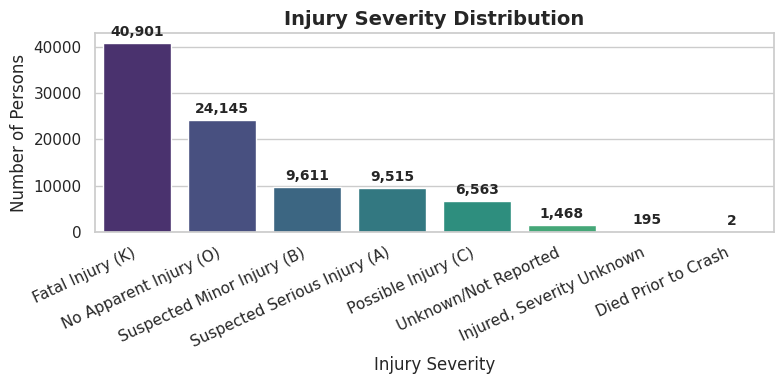

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: reset style
sns.set_theme(style="whitegrid")

# 1) Injury severity distribution
# Why: shows how many are fatal vs minor → central for crash analysis.
plt.figure(figsize=(8, 4))
ax = sns.countplot(
    x='INJ_SEVNAME',
    data=persons_df,
    order=persons_df['INJ_SEVNAME'].value_counts().index,
    palette="viridis"
)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}',       # formatted number (comma separated)
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        xytext=(0, 3), textcoords='offset points'
    )

plt.title("Injury Severity Distribution", fontsize=14, weight='bold')
plt.xlabel("Injury Severity", fontsize=12)
plt.ylabel("Number of Persons", fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# small gap (visual spacer)
plt.figure(figsize=(0.1, 0.1))
plt.axis('off')
plt.show()


/tmp/ipython-input-625606392.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


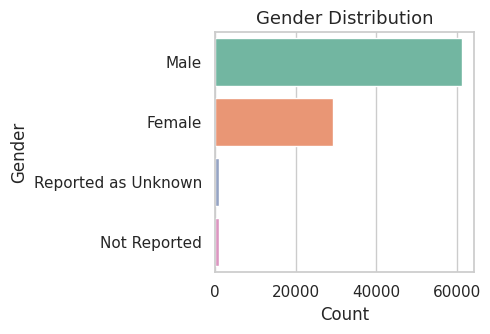

In [ ]:
# 2) Gender distribution (horizontal bar)
# Why: quick demographic split; horizontal fits better for short categories.
plt.figure(figsize=(5,3.5))
sex_counts = persons_df['SEXNAME'].value_counts()
sns.barplot(
    y=sex_counts.index,
    x=sex_counts.values,
    palette="Set2"
)
plt.title("Gender Distribution", fontsize=13)
plt.xlabel("Count")
plt.ylabel("Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(0.1,0.1))
plt.axis('off')
plt.show()

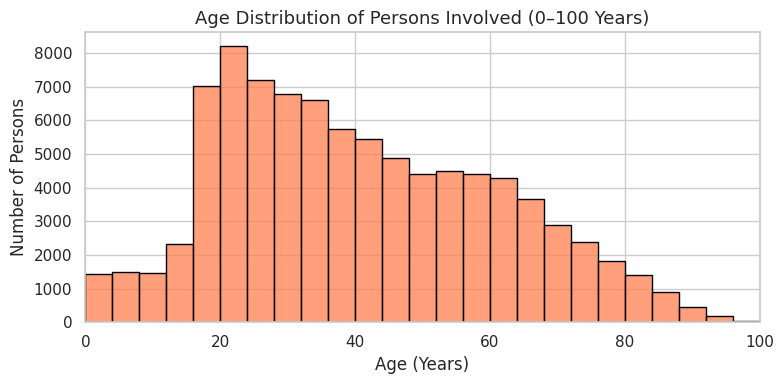

In [ ]:
# 3) Age distribution (histogram)
# Why: visualize realistic age spread (excluding outliers like 998/999 codes).

# Filter out unrealistic ages
valid_age_df = persons_df[(persons_df['AGE'] >= 0) & (persons_df['AGE'] <= 100)]

plt.figure(figsize=(8,4))
sns.histplot(valid_age_df['AGE'], bins=25, color="#FF7F50", edgecolor="black")
plt.title("Age Distribution of Persons Involved (0–100 Years)", fontsize=13)
plt.xlabel("Age (Years)")
plt.ylabel("Number of Persons")
plt.xlim(0, 100)   # set practical range
plt.tight_layout()
plt.show()

# small spacing between plots
plt.figure(figsize=(0.1,0.1))
plt.axis('off')
plt.show()

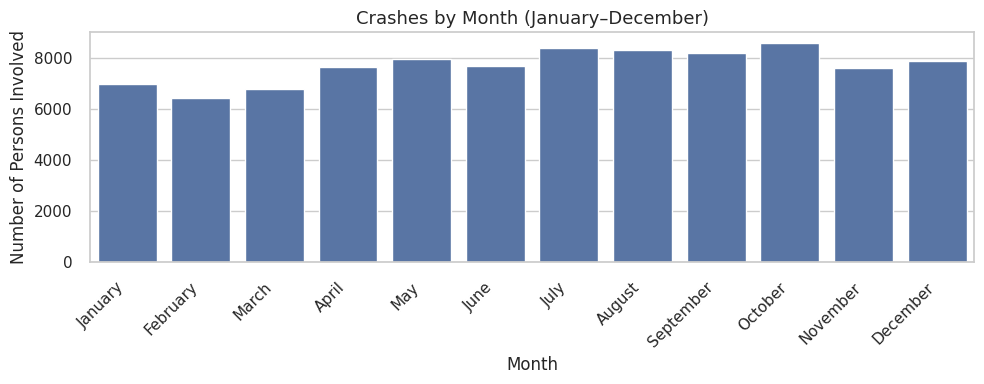

In [ ]:
# 4) Crashes by Month (Chronological Order)
# Why: observe seasonality trends from January to December.

# Define chronological month order
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

plt.figure(figsize=(10,4))
sns.countplot(
    data=persons_df,
    x='MONTHNAME',
    order=month_order,
    color="#4C72B0"
)
plt.title("Crashes by Month (January–December)", fontsize=13)
plt.xlabel("Month")
plt.ylabel("Number of Persons Involved")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# small spacing
plt.figure(figsize=(0.1,0.1))
plt.axis('off')
plt.show()

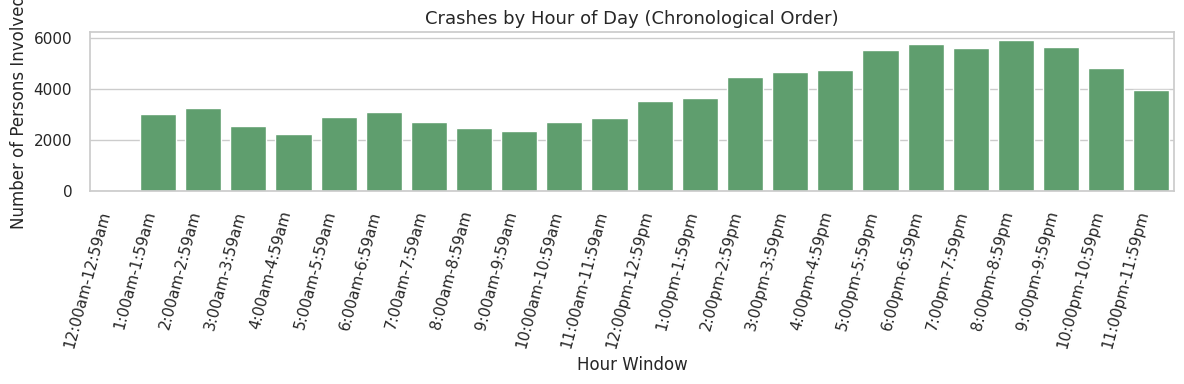

In [ ]:
# 5) Crashes by Hour of Day (Chronological Order)
# Why: helps identify high-risk time windows (late-night, rush hours, etc.)

# Define chronological hour order (matches FARS format)
hour_order = [
    "12:00am-12:59am", "1:00am-1:59am", "2:00am-2:59am", "3:00am-3:59am",
    "4:00am-4:59am", "5:00am-5:59am", "6:00am-6:59am", "7:00am-7:59am",
    "8:00am-8:59am", "9:00am-9:59am", "10:00am-10:59am", "11:00am-11:59am",
    "12:00pm-12:59pm", "1:00pm-1:59pm", "2:00pm-2:59pm", "3:00pm-3:59pm",
    "4:00pm-4:59pm", "5:00pm-5:59pm", "6:00pm-6:59pm", "7:00pm-7:59pm",
    "8:00pm-8:59pm", "9:00pm-9:59pm", "10:00pm-10:59pm", "11:00pm-11:59pm"
]

plt.figure(figsize=(12,4))
sns.countplot(
    data=persons_df,
    x='HOURNAME',
    order=hour_order,
    color="#55A868"
)
plt.title("Crashes by Hour of Day (Chronological Order)", fontsize=13)
plt.xlabel("Hour Window")
plt.ylabel("Number of Persons Involved")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

# small spacing between graphs
plt.figure(figsize=(0.1,0.1))
plt.axis('off')
plt.show()

/tmp/ipython-input-2193839867.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


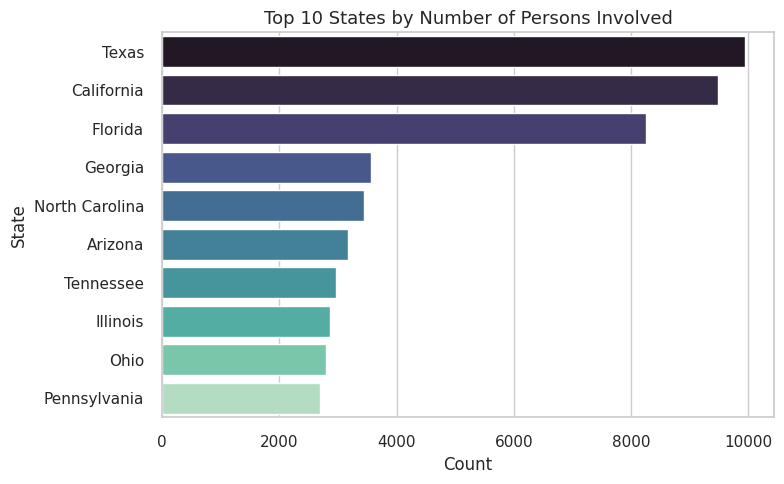

In [ ]:
# 6) Top 10 states (horizontal)
# Why: quick geographic view.
top_states = persons_df['STATENAME'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(
    x=top_states.values,
    y=top_states.index,
    palette="mako"
)
plt.title("Top 10 States by Number of Persons Involved", fontsize=13)
plt.xlabel("Count")
plt.ylabel("State")
plt.tight_layout()
plt.show()

plt.figure(figsize=(0.1,0.1))
plt.axis('off')
plt.show()

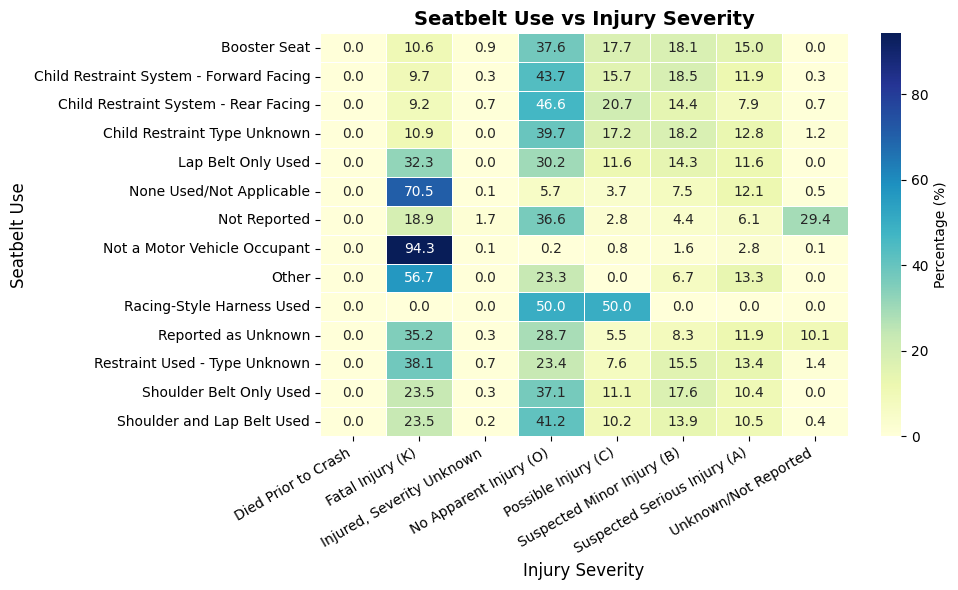

In [8]:
# 7) Seatbelt Use vs Injury Severity (Heatmap)
# Why: shows how seatbelt usage relates to injury outcomes (in %).

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a cross-tab with row-wise percentages
ct = pd.crosstab(
    persons_df['REST_USENAME'],
    persons_df['INJ_SEVNAME'],
    normalize='index'   # normalize within each seatbelt category
) * 100

# Round for cleaner display
ct = ct.round(1)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    ct,
    annot=True,          # show percentage values
    fmt=".1f",           # 1 decimal place
    cmap="YlGnBu",       # blue-green gradient
    linewidths=0.5,
    cbar_kws={"label": "Percentage (%)"}
)

plt.title("Seatbelt Use vs Injury Severity", fontsize=14, weight='bold')
plt.xlabel("Injury Severity", fontsize=12)
plt.ylabel("Seatbelt Use", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


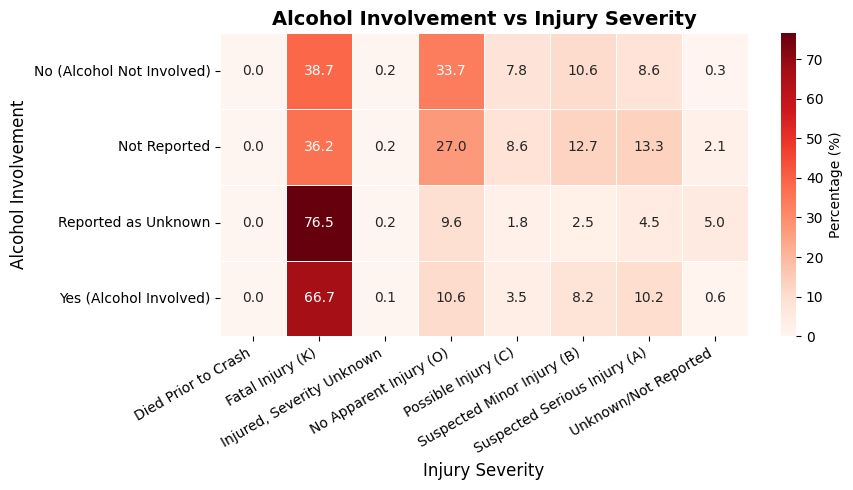

In [9]:
# 8) Alcohol Involvement vs Injury Severity (Heatmap)
# Why: to see if alcohol-involved cases lean toward more severe outcomes.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a cross-tab with row-wise percentages
ct2 = pd.crosstab(
    persons_df['DRINKINGNAME'],
    persons_df['INJ_SEVNAME'],
    normalize='index'   # normalize within each drinking category
) * 100

# Round for cleaner display
ct2 = ct2.round(1)

# Plot the heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(
    ct2,
    annot=True,          # show % values
    fmt=".1f",           # 1 decimal place
    cmap="Reds",         # red gradient to reflect severity
    linewidths=0.5,
    cbar_kws={"label": "Percentage (%)"}
)

plt.title("Alcohol Involvement vs Injury Severity", fontsize=14, weight='bold')
plt.xlabel("Injury Severity", fontsize=12)
plt.ylabel("Alcohol Involvement", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


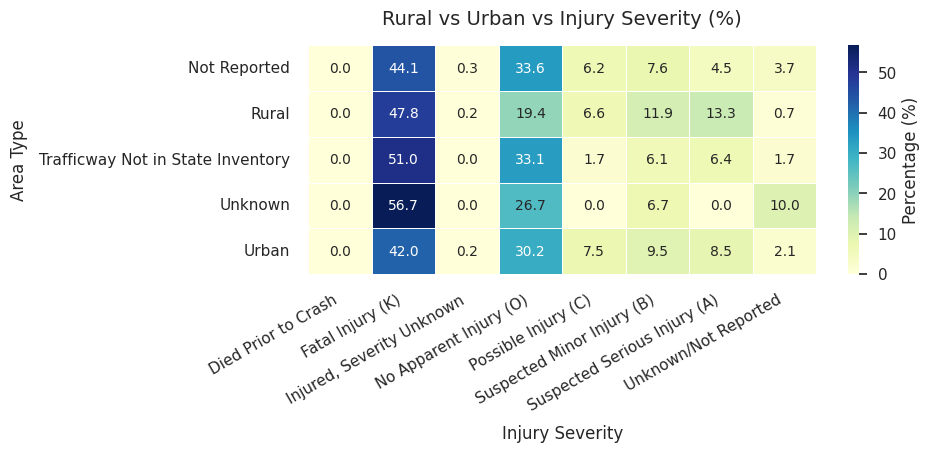

In [ ]:
# 9) Rural vs Urban vs severity

if 'RUR_URBNAME' in persons_df.columns:
    ct_rur = pd.crosstab(persons_df['RUR_URBNAME'], persons_df['INJ_SEVNAME'], normalize='index') * 100

    plt.figure(figsize=(10,5))  # wider for better spacing
    sns.heatmap(
        ct_rur,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=0.4,
        cbar_kws={"label": "Percentage (%)"},
        annot_kws={"size": 10}
    )
    plt.title("Rural vs Urban vs Injury Severity (%)", fontsize=14, pad=15)
    plt.xlabel("Injury Severity", fontsize=12, labelpad=8)
    plt.ylabel("Area Type", fontsize=12, labelpad=8)
    plt.xticks(rotation=30, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout(pad=2.0)
    plt.show()

    # small blank space between plots
    plt.figure(figsize=(0.1, 0.1))
    plt.axis('off')
    plt.show()

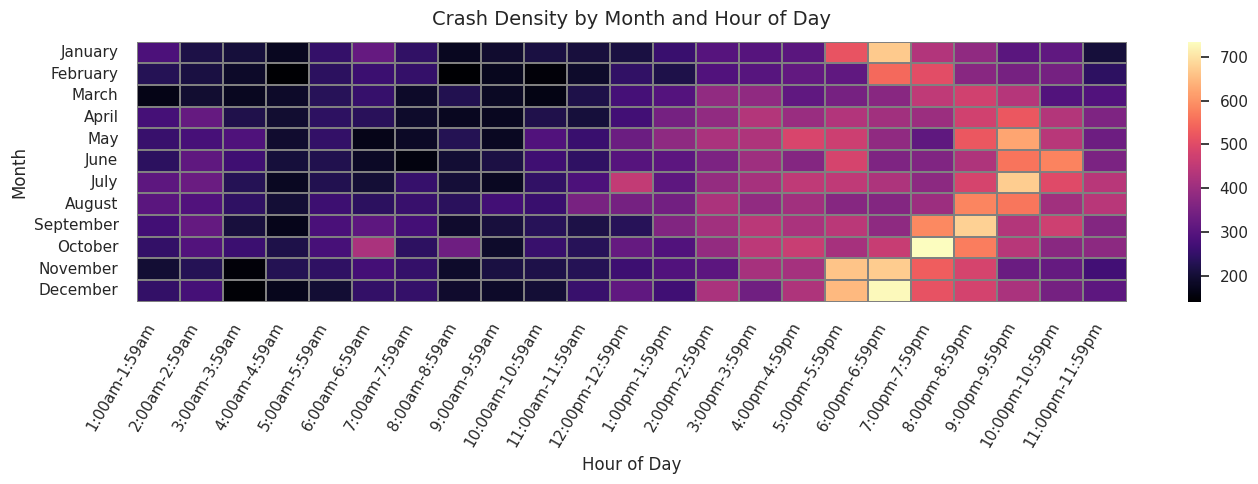

In [ ]:
# 10
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# base lists (full)
month_order_full = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

hour_order_full = [
    "12:00am-12:59am", "1:00am-1:59am", "2:00am-2:59am", "3:00am-3:59am",
    "4:00am-4:59am", "5:00am-5:59am", "6:00am-6:59am", "7:00am-7:59am",
    "8:00am-8:59am", "9:00am-9:59am", "10:00am-10:59am", "11:00am-11:59am",
    "12:00pm-12:59pm", "1:00pm-1:59pm", "2:00pm-2:59pm", "3:00pm-3:59pm",
    "4:00pm-4:59pm", "5:00pm-5:59pm", "6:00pm-6:59pm", "7:00pm-7:59pm",
    "8:00pm-8:59pm", "9:00pm-9:59pm", "10:00pm-10:59pm", "11:00pm-11:59pm"
]

# keep only the ones that actually appear in your data
months_present = [m for m in month_order_full if m in persons_df['MONTHNAME'].unique()]
hours_present = [h for h in hour_order_full if h in persons_df['HOURNAME'].unique()]

# build crosstab from actual data
month_hour = pd.crosstab(
    persons_df['MONTHNAME'],
    persons_df['HOURNAME']
)

# reindex ONLY to present values, and fill missing with 0
month_hour = (
    month_hour
    .reindex(index=months_present, columns=hours_present)
    .fillna(0)
)

plt.figure(figsize=(14,5))
sns.heatmap(
    month_hour,
    cmap="magma",
    linewidths=0.3,
    linecolor="gray"
)
plt.title("Crash Density by Month and Hour of Day", fontsize=14, pad=12)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


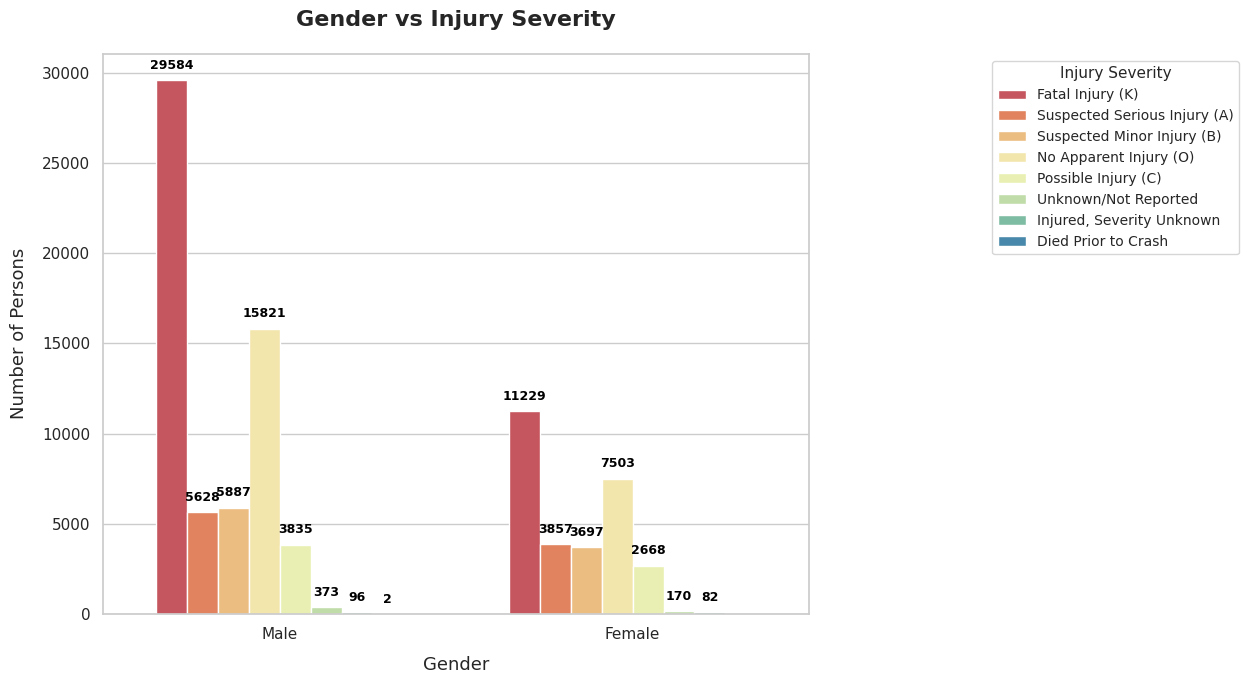

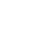

In [13]:
# ----------------------------------------------------
# 11) Gender vs Injury Severity (Male & Female only — spacious version)
# ----------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter to include only Male and Female
gender_df = persons_df[persons_df['SEXNAME'].isin(['Male', 'Female'])].copy()

# Create grouped bar chart with extra space
fig, ax = plt.subplots(figsize=(13, 7))
sns.countplot(
    data=gender_df,
    x='SEXNAME',
    hue='INJ_SEVNAME',
    palette='Spectral',
    ax=ax,
    width=0.7   # slightly thinner bars for spacing
)

# Add count labels — well-spaced above bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%d',
        label_type='edge',
        fontsize=9,
        fontweight='bold',
        padding=6,         # more space above bars
        color='black'
    )

# Titles and axis labels
ax.set_title("Gender vs Injury Severity", fontsize=16, weight='bold', pad=20)
ax.set_xlabel("Gender", fontsize=13, labelpad=10)
ax.set_ylabel("Number of Persons", fontsize=13, labelpad=10)

# Legend on the right with extra gap
ax.legend(
    title="Injury Severity",
    bbox_to_anchor=(1.25, 1),
    loc="upper left",
    fontsize=10,
    title_fontsize=11
)

# Adjust subplot margins to leave plenty of room
plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.12)
plt.tight_layout()
plt.show()

# Spacer (visual gap between plots)
plt.figure(figsize=(0.2, 0.2))
plt.axis('off')
plt.show()


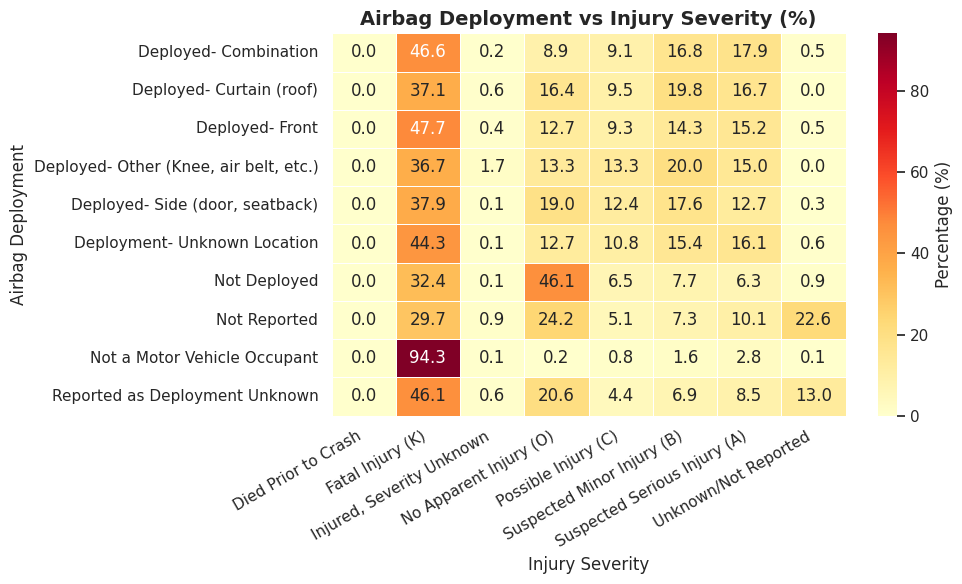

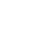

In [14]:
# 12) Airbag Deployment vs Injury Severity (Heatmap, % like seatbelt one)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crosstab with row-wise % (each airbag category sums to 100)
ct_airbag = pd.crosstab(
    persons_df['AIR_BAGNAME'],
    persons_df['INJ_SEVNAME'],
    normalize='index'
) * 100

# Round for cleaner display
ct_airbag = ct_airbag.round(1)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    ct_airbag,
    annot=True,             # show percentages
    fmt=".1f",
    cmap="YlOrRd",          # keep your colors
    linewidths=0.5,
    cbar_kws={"label": "Percentage (%)"}
)

plt.title("Airbag Deployment vs Injury Severity (%)", fontsize=14, weight='bold')
plt.xlabel("Injury Severity", fontsize=12)
plt.ylabel("Airbag Deployment", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# spacer
plt.figure(figsize=(0.2, 0.2))
plt.axis('off')
plt.show()


/tmp/ipython-input-3231700116.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


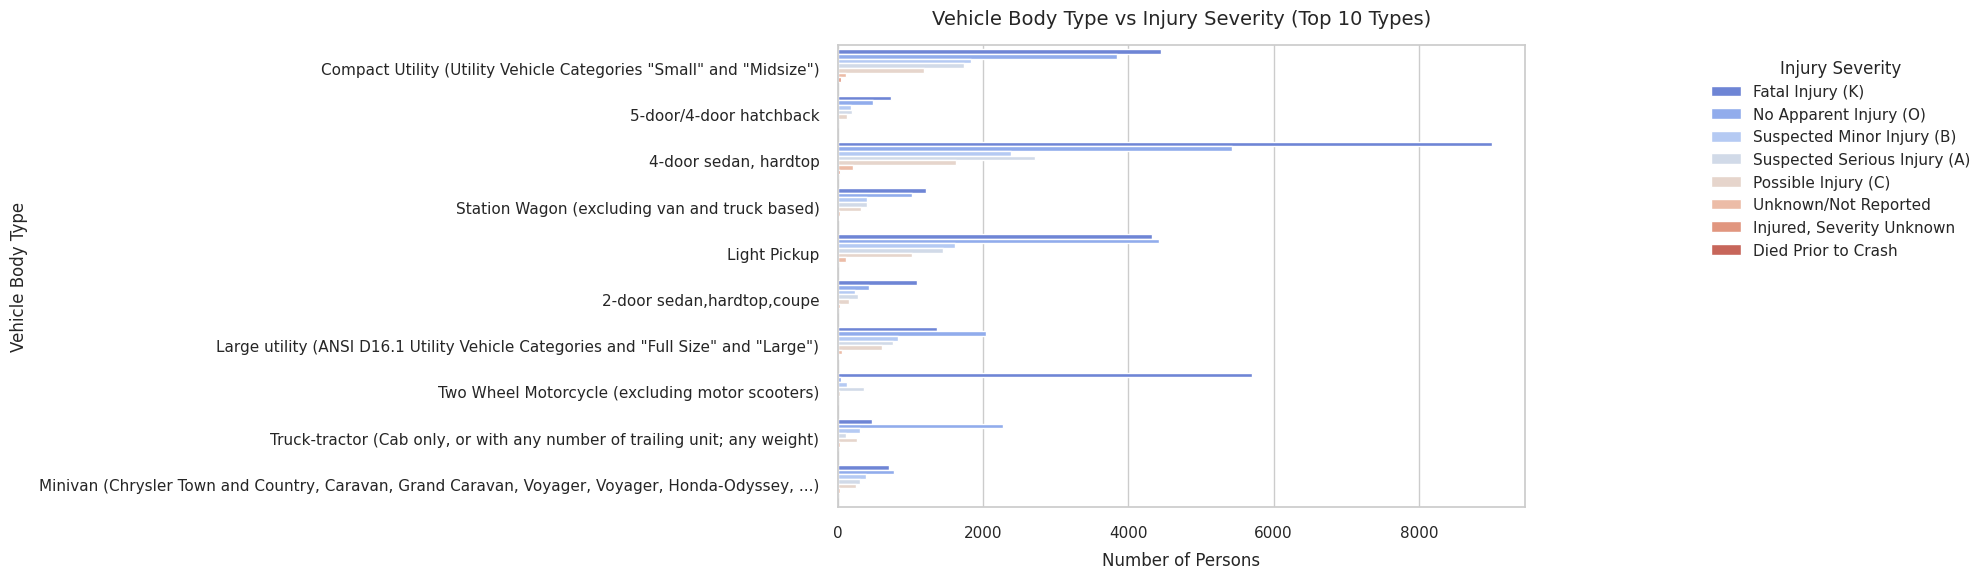

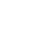

In [ ]:
# 13) Vehicle Body Type vs Injury Severity

plt.figure(figsize=(11, 6))

top_bodies = persons_df['BODY_TYPNAME'].value_counts().head(10).index

sns.countplot(
    data=persons_df[persons_df['BODY_TYPNAME'].isin(top_bodies)],
    y='BODY_TYPNAME',
    hue='INJ_SEVNAME',
    palette='coolwarm',
    hue_order=persons_df['INJ_SEVNAME'].value_counts().index  # keeps legend order consistent
)

plt.title("Vehicle Body Type vs Injury Severity (Top 10 Types)", fontsize=14, pad=15)
plt.xlabel("Number of Persons", fontsize=12, labelpad=8)
plt.ylabel("Vehicle Body Type", fontsize=12, labelpad=8)

# cleaner legend to the right with more space
plt.legend(
    title="Injury Severity",
    bbox_to_anchor=(1.25, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.show()

# spacer
plt.figure(figsize=(0.2, 0.2))
plt.axis('off')
plt.show()

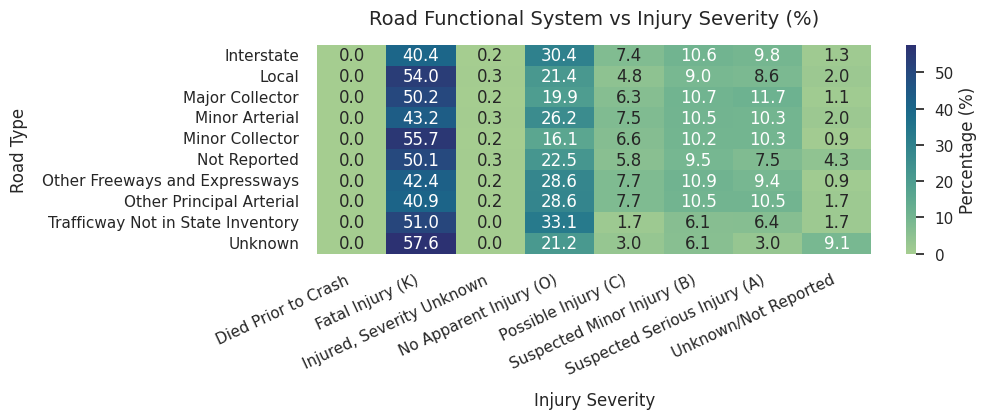

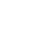

In [ ]:
# 14) Road Functional System vs Injury Severity

plt.figure(figsize=(11, 5))

ct_func = (
    pd.crosstab(
        persons_df['FUNC_SYSNAME'],
        persons_df['INJ_SEVNAME'],
        normalize='index'
    ) * 100
)

sns.heatmap(
    ct_func,
    annot=True,
    fmt=".1f",
    cmap="crest",
    cbar_kws={'label': 'Percentage (%)'}
)

plt.title("Road Functional System vs Injury Severity (%)", fontsize=14, pad=15)
plt.xlabel("Injury Severity", fontsize=12, labelpad=10)
plt.ylabel("Road Type", fontsize=12, labelpad=10)

plt.xticks(rotation=25, ha='right')
plt.yticks(rotation=0)

plt.tight_layout(pad=3)
plt.show()



# spacer
plt.figure(figsize=(0.2, 0.2))
plt.axis('off')
plt.show()

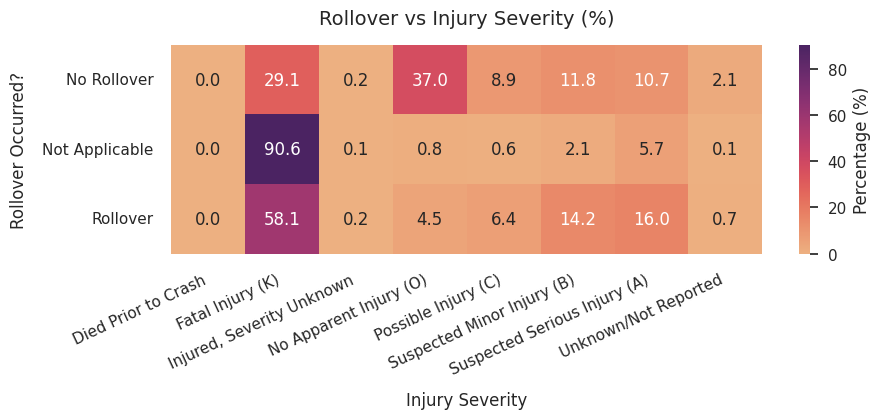

In [ ]:
# 15) Rollover vs Injury Severity

plt.figure(figsize=(10, 5))

ct_roll = (
    pd.crosstab(
        persons_df['ROLLOVERNAME'],
        persons_df['INJ_SEVNAME'],
        normalize='index'
    ) * 100
)

sns.heatmap(
    ct_roll,
    annot=True,
    fmt=".1f",
    cmap="flare",
    cbar_kws={'label': 'Percentage (%)'}
)

plt.title("Rollover vs Injury Severity (%)", fontsize=14, pad=15)
plt.xlabel("Injury Severity", fontsize=12, labelpad=10)
plt.ylabel("Rollover Occurred?", fontsize=12, labelpad=10)

plt.xticks(rotation=25, ha='right')
plt.yticks(rotation=0)

plt.tight_layout(pad=3)
plt.show()